# Notebook Goals
- Detect deepfake images with huggingface model
- test batches of 1,2,3 of images on training time
- run n_cores models concurrently

In [1]:
# Setup
from huggingface_hub import hf_hub_download
from datasets import load_dataset
from transformers import pipeline
# from ray.util.multiprocessing import Pool
import time
# import ray
import os
#import torch 
os.chdir("C:\\Users\\WulfN\\.cache\\huggingface\\hub\\")

%config InteractiveShell.ast_node_interactivity = 'all'
# download model
# hf_hub_download(repo_id = 'prithivMLmods/Deep-Fake-Detector-Model', filename = 'config.json') # presumably the config file is needed first
# model.safetensors, # pytorch_model.bin

# Datasets can be found here: https://huggingface.co/datasets?modality=modality:image&sort=trending&search=deepfake


n_cores = os.cpu_count()

### Load Data
image_dt = load_dataset("Whab/deepfake")

# Using torch
# torch.utils.data.Dataset
# dataset = DataLoader(
#     hugging_face_data,
#     batch_size=3, # try 2, 3, or 4
#     shuffle=True,
#     num_workers=n_cores,
#     pin_memory=True
# )

OSError: [WinError 126] The specified module could not be found. Error loading "c:\Users\WulfN\Python Projects\learn_ts\ts_env_310\lib\site-packages\torch\lib\aoti_custom_ops.dll" or one of its dependencies.

In [ ]:
# ray.shutdown()
# ray.init(num_cpus=os.cpu_count())

Preview dataset images

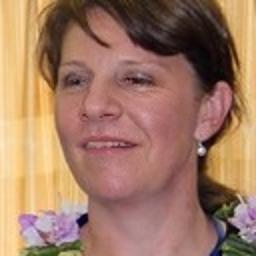

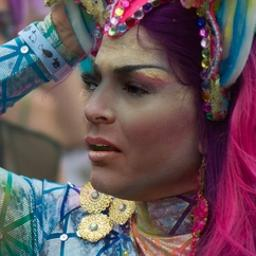

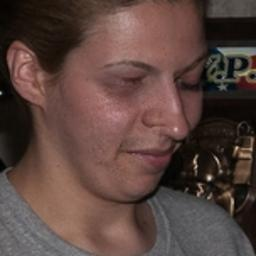

In [12]:
import ipywidgets as widgets
from IPython.display import display

preview_num = 3
sample_images = image_dt['train'][1+10:preview_num+11]
## Display images vertically
for i in range(preview_num):
    display(sample_images['image'][i])


Function to create batches of image data

In [7]:
# import pandas as pd
# import numpy as np
# # import modin as pd

# #@ray.remote
# def create_image_batches(data, batch_size):
    
#     num_images = data.num_rows # data[0].num_rows may be needed when using starmap
#     batch_size = batch_size + 1

#     # index value of first image in batch i
#     batch_key = list(range(0, num_images, batch_size))

#     # initializing result dataframe
#     result = pd.DataFrame({'image_batch':[]})

#     # batching images in groups of chunk_size
#     for i in range(len(batch_key)):

#         # index of all images in batch
#         last_batch_adjustment = (num_images - max(batch_key))
#         batch_indices = list(range(batch_key[i], batch_key[i] + last_batch_adjustment))

#         # appending images from batch into list
#         batched_images = []
#         for j in batch_indices:
#             batched_images.append(data[j]['image'])

#         batch = pd.DataFrame({'image_batch': [batched_images]})
        
#         # combining batches into pandas dataframe
#         result = pd.concat([result, batch])
            
#     return result


Batching images prior to modeling

In [ ]:
# import torch

# # Goal: Learn torch and parallelize this process

# device = torch.device("mps" if torch.backends.mps.is_available() else 
#                      "cuda" if torch.cuda.is_available() else "cpu")

# # Create test dataset
# n_cores = os.cpu_count()
#  

# # Create arguments for starmap
# args = []
# batch_size = 3
# for i in range(n_cores):
#     chunk = test_df['test'].shard(num_shards=n_cores, index=i)
#     #chunk = dataset['train'].shard(num_shards=n_cores, index=i)
#     args.append((chunk, batch_size + 1))

# # create image batches in parallel
# if __name__ == "__main__":

#     start = time.time()

#     #batched_images = ray.get([create_image_batches.remote(*a) for a in args])

#     pool = Pool(n_cores)
#     batched_images = pool.starmap(create_image_batches, args)
#     batched_images

#     end = time.time() - start
#     print('Process complete in: ', end)
    
# # run 1: 37.7 seconds
# # run 2: 54.9 seconds
# # run 3: 32.6 seconds
# # run 4: 55.8 seconds
# # run 5: 17.7 seconds 
# # run 6: 45.7 seconds
# # run 7: 

In [ ]:
# # prep test data
# test_dt = image_dt['train'].train_test_split(test_size=0.1, shuffle=False, seed=25)
# test_dt['test']['image'] # 17943 images
# #test_dt['train']

In [ ]:
from torch.utils.data import DataLoader 

dataloader = DataLoader(
    image_dt,
    batch_size=2, # try 2, 3, or 4
    shuffle=False,
    num_workers=n_cores,
    pin_memory=True
)


Prepare Model Pipeline with HuggingFace Model

In [ ]:
# Had success with Python 3.10 from Python 3.12, now experience difficulties with importing torch
import torch
# import intel_extension_for_pytorch as ipex
# print(torch.__version__)
# print(ipex.__version__) 
# [print(f'[{i}]: {torch.xpu.get_device_properties(i)}') for i in range(torch.xpu.device_count())]

Sequential Inference

In [ ]:

# predictions = pd.DataFrame({'index': [], 'label': [], 'score': []})
# # w/ # pipe.enable_sequential_cpu_offload()
# pipe = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", device=-1); 
# for i in range(test_df['test'].num_rows):
#     res = pipe(test_df['test'][i]['image']) 
#     predictions = pd.concat([predictions, pd.DataFrame(res).assign(index=i)])

# predictions.head()


Paralellized Inference

In [ ]:
# Save table in repo
import pickle
predictions.to_pickle('huggingface_predictions')

dist'n of fake and real scores

In [ ]:
# dist'n of fake and real scores
import seaborn as sb
sb.displot(kind='hist', data=predictions.loc[lambda x: x.label == 'Fake'], bins=100)
sb.displot(kind='hist', data=predictions.loc[lambda x: x.label == 'Real'], bins=100)